# 00. Librerías

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sn

In [29]:
import plotly.express as px

# 01. Carga de datos

In [2]:
base_path = 'C:\\Users\\monts\\Practica2\\project'

In [3]:
parquet_file = os.path.join(base_path, "data_procesada", 'datos_clustering.parquet')

In [4]:
df = pd.read_parquet(parquet_file)

In [5]:
df.shape

(33642, 19)

In [6]:
df.columns

Index(['year_db', 'ent_ocurr', 'mun_ocurr', 'ent_resid', 'mun_resid',
       'age_final', 'sexo', 'edo_civil', 'escolaridad_agrup', 'cond_act',
       'ocupacion_agrup', 'asist_medi', 'derechohab_agrup', 'area_urbana',
       'metodo_suicidio', 'lugar_ocurrencia', 'sitio_ocurrencia',
       'ciclo_horario', 'mes_ocurr'],
      dtype='object')

# 02. OHE

In [7]:
# Preparación de variables
scalar_column = ['age_final'] 

# Columnas que pasará a OHE
ohe_columns = [
    'sexo',
    'edo_civil',
    'escolaridad_agrup',         
    'ocupacion_agrup',
    'asist_medi',
    'derechohab_agrup',
    'area_urbana',
    'metodo_suicidio',
    'lugar_ocurrencia',
    'sitio_ocurrencia',
    'ciclo_horario'
]

# Columnas que no jugarán en el modelado
exclude_model = ['year_db', 'ent_ocurr', 'mun_ocurr', 'ent_resid', 'mun_resid', 'cond_act', 'mes_ocurr']

In [8]:
# Preparación | OHE
df_model = df.drop(columns=exclude_model).copy()
X_ohe = pd.get_dummies(df_model, columns=ohe_columns, drop_first=True)

# Escalado para la edad
scaler = StandardScaler()
X_ohe[scalar_column] = scaler.fit_transform(X_ohe[scalar_column])

X_final = X_ohe

# 03. Determinación de clusters

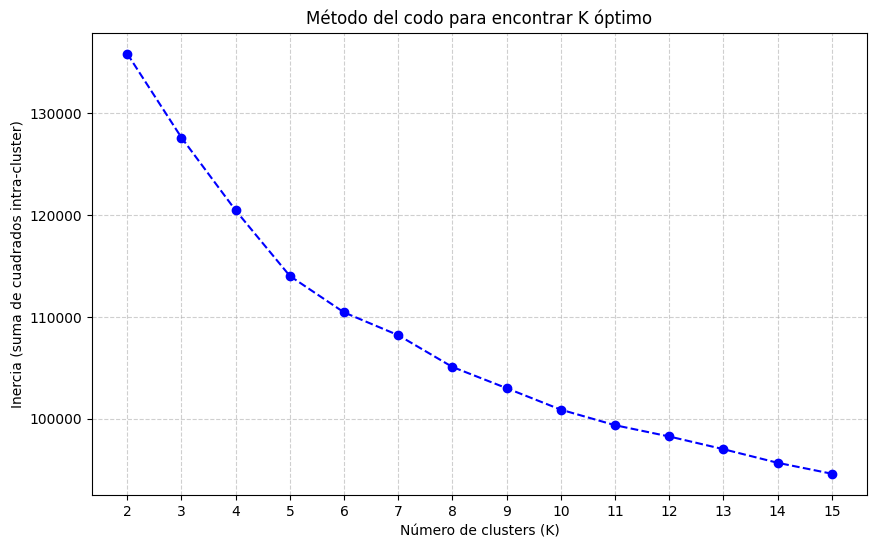

In [9]:
# Gráfico del codo para determinar el número de clusters
# Inercia
inercia = []
rango_k = range(2, 16) # De 2 a 15 clusters

# Cálculo de la inercia para cada K
for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X_final)
    inercia.append(kmeans.inertia_)

# Gráfico del Codo
plt.figure(figsize=(10, 6))
plt.plot(rango_k, inercia, marker='o', linestyle='--', color='blue')
plt.title('Método del codo para encontrar K óptimo')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia (suma de cuadrados intra-cluster)')
plt.xticks(rango_k)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 04. Modelado

In [10]:
# Rango de evaluación
RANGO_K = range(3, 9) 

resultados_silueta = {}
mejores_modelos = {}

# Evaluación con diferentes agrupamientos
for k in RANGO_K:
    # Entrenamiento
    kmeans = KMeans(n_clusters=k, random_state=134, n_init=20)
    kmeans.fit(X_final)
    
    # Calculo del índice de silueta
    if k > 1 and k < len(X_final):
        score = silhouette_score(X_final, kmeans.labels_)

        resultados_silueta[k] = score
        mejores_modelos[k] = kmeans
        
        print(f"K = {k}: Índice de silueta = {score:.4f}")
    else:
        print(f"K = {k} no es válido para el cálculo de silueta.")

# Identificación de clusters
k_optimo_silueta = max(resultados_silueta, key=resultados_silueta.get)
puntaje_optimo = resultados_silueta[k_optimo_silueta]

print("\n-------------------------------------------")
print(f"El K óptimo por índice de silueta es: K = {k_optimo_silueta}")
print(f"Con un puntaje de silueta de: {puntaje_optimo:.4f}")

K = 3: Índice de silueta = 0.0948
K = 4: Índice de silueta = 0.0942
K = 5: Índice de silueta = 0.0968
K = 6: Índice de silueta = 0.0875
K = 7: Índice de silueta = 0.0750
K = 8: Índice de silueta = 0.0768

-------------------------------------------
El K óptimo por índice de silueta es: K = 5
Con un puntaje de silueta de: 0.0968


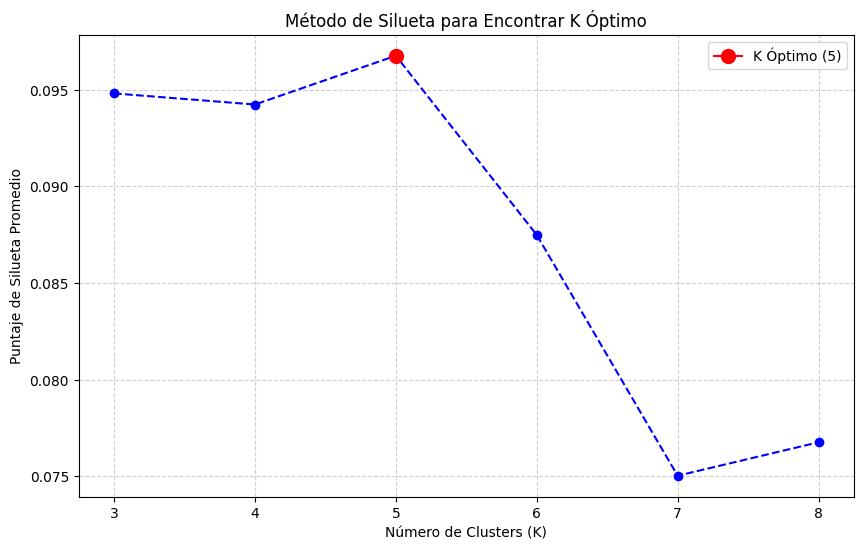

In [11]:
# Gráfico del índice de silueta
K_values = list(resultados_silueta.keys())
scores = list(resultados_silueta.values())

plt.figure(figsize=(10, 6))
plt.plot(K_values, scores, marker='o', linestyle='--', color='blue')

# Mejor número de clusters
k_optimo = max(resultados_silueta, key=resultados_silueta.get)
score_optimo = resultados_silueta[k_optimo]
plt.plot(k_optimo, score_optimo, marker='o', markersize=10, color='red', label=f'K Óptimo ({k_optimo})')

plt.title('Método de Silueta para Encontrar K Óptimo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Puntaje de Silueta Promedio')
plt.xticks(K_values) 
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [12]:
# Modelo final
K_OPTIMO = k_optimo_silueta

# Entrenamiento
kmeans_final = KMeans(n_clusters=K_OPTIMO, random_state=134, n_init=20)
kmeans_final.fit(X_final)

# Etiquetas
etiquetas_finales = kmeans_final.labels_

In [13]:
silhouette_score(X_final, kmeans_final.labels_)

0.0967581867201597

# 05. Perfilamiento

In [14]:
df['cluster'] = etiquetas_finales 

In [15]:
# Cálculo de la moda
def get_mode(x):
    return x.mode()[0] if not x.empty else np.nan

In [16]:
# Perfilamiento
perfiles = df.groupby('cluster').agg(
    # Numéricos: Media
    age_final=('age_final', 'mean'),
    
    # Categóricos: Moda (valor más frecuente)
    sexo=('sexo', get_mode),
    edo_civil=('edo_civil', get_mode),
    escolaridad=('escolaridad_agrup', get_mode),
    asist_medica=('asist_medi', get_mode),
    ocupacion_agrup=('ocupacion_agrup', get_mode),
    metodo=('metodo_suicidio', get_mode),
    sitio=('sitio_ocurrencia', get_mode),
    lugar=('lugar_ocurrencia', get_mode),
    ciclo_horario=('ciclo_horario', get_mode),
    mes_frecuente=('mes_ocurr', get_mode), 
    
    tamano_temp=('cluster', 'size')
)

In [17]:
perfiles.reset_index(inplace=True)
perfiles.rename(columns={
    'age_final': 'Edad promedio', 
    'mes_frecuente': 'Mes ocurrencia',
    'tamano_temp': 'Tamaño' 
}, inplace=True)

In [18]:
# Resumen de perfiles
print("\n--- Perfiles de riesgo (K=5) ---")
print(perfiles)


--- Perfiles de riesgo (K=5) ---
   cluster  Edad promedio    sexo  edo_civil escolaridad  asist_medica  \
0        0      32.711605  Hombre          1       Media             2   
1        1      32.232393  Hombre          1       Media             2   
2        2      30.990787  Hombre          1       Media             9   
3        3      22.685014  Hombre          1       Media             2   
4        4       60.47969  Hombre          5      Basica             2   

   ocupacion_agrup        metodo            sitio       lugar  \
0          Trabaja  Ahorcamiento  No_especificado  Otro lugar   
1          Trabaja  Ahorcamiento            Hogar    Vivienda   
2  No_especificado  Ahorcamiento            Hogar    Vivienda   
3       No_trabaja  Ahorcamiento            Hogar    Vivienda   
4          Trabaja  Ahorcamiento            Hogar    Vivienda   

       ciclo_horario  Mes ocurrencia  Tamaño  
0  Madrugada (00-05)               7    5222  
1      Noche (18-23)               6

In [19]:
# Mapeo de categorías

# Meses
MES_NOMBRES = {1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun', 
               7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dic'}

# Estado Civil
EDO_CIVIL_NOMBRES = {1: 'Soltero', 5: 'Casado', 2: 'Divorciado', 6: 'Separado', 3: 'Viudo', 4: 'Union libre', 9:'NE'}

# Nivel Educativo
ESCOLARIDAD_NOMBRES = {'Media': 'Media Superior', 'Basica': 'Básica'} 

# Asistencia Médica
ASIST_MEDICA_NOMBRES = {1: 'Con Asistencia', 2: 'Sin Asistencia', 9: 'NE'}

# Remapeo
perfiles['Mes ocurrencia'] = perfiles['Mes ocurrencia'].map(MES_NOMBRES)
perfiles['edo_civil'] = perfiles['edo_civil'].map(EDO_CIVIL_NOMBRES)
perfiles['escolaridad'] = perfiles['escolaridad'].map(ESCOLARIDAD_NOMBRES)
perfiles['asist_medica'] = perfiles['asist_medica'].map(ASIST_MEDICA_NOMBRES)

In [20]:
display(perfiles)

,cluster,Edad promedio,sexo,edo_civil,escolaridad,asist_medica,ocupacion_agrup,metodo,sitio,lugar,ciclo_horario,Mes ocurrencia,Tamaño
0,0,32.711605,Hombre,Soltero,Media Superior,Sin Asistencia,Trabaja,Ahorcamiento,No_especificado,Otro lugar,Madrugada (00-05),Jul,5222
1,1,32.232393,Hombre,Soltero,Media Superior,Sin Asistencia,Trabaja,Ahorcamiento,Hogar,Vivienda,Noche (18-23),Jun,9854
2,2,30.990787,Hombre,Soltero,Media Superior,NE,No_especificado,Ahorcamiento,Hogar,Vivienda,Madrugada (00-05),Sep,4776
3,3,22.685014,Hombre,Soltero,Media Superior,Sin Asistencia,No_trabaja,Ahorcamiento,Hogar,Vivienda,Noche (18-23),Mar,7340
4,4,60.47969,Hombre,Casado,Básica,Sin Asistencia,Trabaja,Ahorcamiento,Hogar,Vivienda,Tarde (12-17),May,6450


In [22]:
# Tabla pefiles de riesgo

# Grupos
nombres_perfil = {
    0: "Adulto Joven - riesgo nocturno",
    1: "Adulto Joven - riesgo vespertino",
    2: "Adulto Joven - riesgo no especificado",
    3: "Adulto Joven - sin ocupación",
    4: "Adulto Mayor - analfabetismo"
}

perfiles['Nombre del Perfil'] = perfiles['cluster'].map(nombres_perfil)

In [23]:
display(perfiles)

,cluster,Edad promedio,sexo,edo_civil,escolaridad,asist_medica,ocupacion_agrup,metodo,sitio,lugar,ciclo_horario,Mes ocurrencia,Tamaño,Nombre del Perfil
0,0,32.711605,Hombre,Soltero,Media Superior,Sin Asistencia,Trabaja,Ahorcamiento,No_especificado,Otro lugar,Madrugada (00-05),Jul,5222,Adulto Joven - riesgo nocturno
1,1,32.232393,Hombre,Soltero,Media Superior,Sin Asistencia,Trabaja,Ahorcamiento,Hogar,Vivienda,Noche (18-23),Jun,9854,Adulto Joven - riesgo vespertino
2,2,30.990787,Hombre,Soltero,Media Superior,NE,No_especificado,Ahorcamiento,Hogar,Vivienda,Madrugada (00-05),Sep,4776,Adulto Joven - riesgo no especificado
3,3,22.685014,Hombre,Soltero,Media Superior,Sin Asistencia,No_trabaja,Ahorcamiento,Hogar,Vivienda,Noche (18-23),Mar,7340,Adulto Joven - sin ocupación
4,4,60.47969,Hombre,Casado,Básica,Sin Asistencia,Trabaja,Ahorcamiento,Hogar,Vivienda,Tarde (12-17),May,6450,Adulto Mayor - analfabetismo


# 06. Visualización de grupos

In [24]:
# Reducción de dimensionalidad
tsne = TSNE(n_components=2, random_state=134, perplexity=20, max_iter=2000)
X_tsne = tsne.fit_transform(X_final)

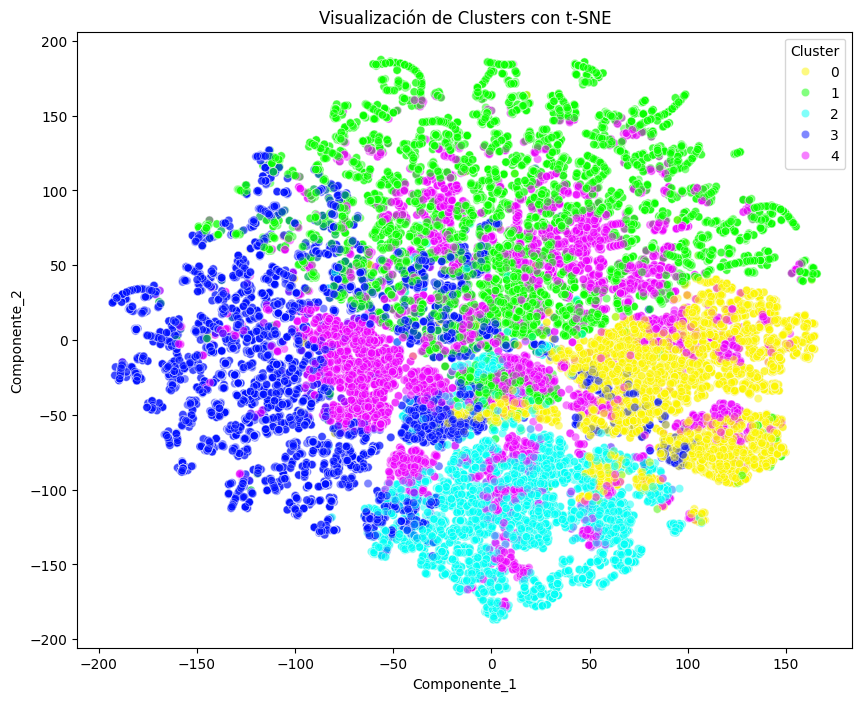

In [26]:
# Visualización
df_tsne = pd.DataFrame(data = X_tsne, columns = ['Componente_1', 'Componente_2'])
df_tsne['Cluster'] = df['cluster'] # Asignamos la etiqueta del cluster

plt.figure(figsize=(10, 8))
sn.scatterplot(
    x="Componente_1", y="Componente_2",
    hue="Cluster",
    palette=sn.color_palette("hsv", K_OPTIMO),
    data=df_tsne,
    legend="full",
    alpha=0.5
)
plt.title('Visualización de Clusters con t-SNE')
plt.show()

In [27]:
# t-SNE para 3 dimensiones
tsne_3d = TSNE(n_components=3, random_state=134, perplexity=20) # Mantén la perplejidad que funcionó
tsne_3d_results = tsne_3d.fit_transform(X_final) # X_final es tu matriz de datos escalados

df_tsne_3d = pd.DataFrame(
    tsne_3d_results, 
    columns=['Componente_1', 'Componente_2', 'Componente_3']
)

# Etiquetas
df_tsne_3d['cluster'] = etiquetas_finales.astype(str) 

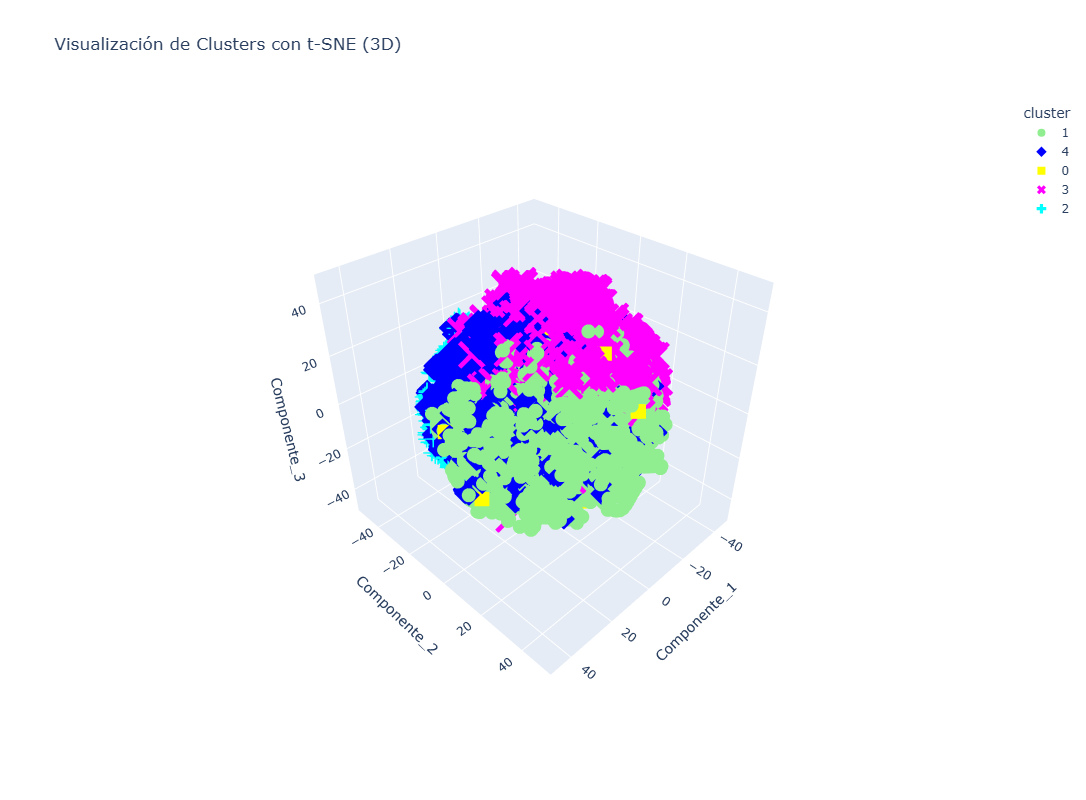

In [33]:
# Visualización 3d
fig_3d = px.scatter_3d(
    df_tsne_3d,
    x='Componente_1',
    y='Componente_2',
    z='Componente_3',
    color='cluster',
    symbol='cluster', # diferenciador 
    hover_data=['cluster'],
    title='Visualización de Clusters con t-SNE (3D)',
    color_discrete_map={'0': 'yellow', '1': 'lightgreen', '2': 'cyan', '3': 'magenta', '4': 'blue'}
)

fig_3d.update_layout(
    height=800, 
    width=1000,  
    
    # Tamaño del marcador
    scene=dict(
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5) # Posición inicial de la cámara
        )
    )
)

fig_3d.show() 

In [34]:
# Salida visualización 3d
fig_3d.write_html("tsne_3d_interactivo.html") 

In [35]:
# Salida
file_name = 'datos_agrupados.parquet'
output_path = os.path.join(base_path, 'data_procesada')
parquet_file = os.path.join(output_path, file_name)
df.to_parquet(parquet_file, index=False)

In [37]:
# Salida para Streamlit
file_name_csv = 'perfiles.csv'
output_path = os.path.join(base_path, 'outputs')
csv_file = os.path.join(output_path, file_name_csv)
perfiles.to_csv(csv_file, index=False, encoding = 'utf-8')

In [45]:
# tsne 3d
import json

CLUSTER_NOMBRES = {
    '0': 'Adulto Joven - riesgo nocturno',
    '1': 'Adulto Joven - riesgo vespertino',
    '2': 'Adulto Joven - riesgo no especificado',
    '3': 'Adulto Joven - sin ocupación',
    '4': 'Adulto Mayor - analfabetismo' 
}

df_tsne_3d['cluster_nombre'] = df_tsne_3d['cluster'].map(CLUSTER_NOMBRES)

In [50]:
df_tsne_3d.to_csv('tsne_3d_data.csv', index=False, encoding='utf-8') 